# Model Development: Time-Series Crop Yield Prediction

**Objective:** To develop and compare multiple machine learning models to predict future crop yield (`hg/ha_yield`) based on historical data. 

This notebook will:
1.  Load the cleaned dataset from the previous EDA.
2.  Preprocess the data for both tabular and time-series (sequential) modeling.
3.  Implement a chronological train-validation-test split.
4.  Build, train, and evaluate five model families:
    * Linear Regression (Baseline)
    * XGBoost Regressor
    * Feedforward Neural Network (NN)
    * 1D Convolutional Neural Network (CNN)
    * Long Short-Term Memory (LSTM) Network
5.  Compare all models on key metrics (RMSE, MAE, R²) and discuss trade-offs.

## 1. Setup and Import

Import all necessary libraries for data manipulation, preprocessing, modeling, and evaluation.

In [25]:
# Data Manipulation
import pandas as pd
import numpy as np
import os
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Classic ML Models
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Deep Learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set plotting styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [26]:
# Load the cleaned dataset
try:
    df = pd.read_csv('cleaned_crop_data.csv')
    print("cleaned_crop_data.csv loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'cleaned_crop_data.csv' not found.")
    print("Please ensure the file from the EDA notebook is in the same directory.")
    df = pd.DataFrame() # Create empty df to avoid downstream errors

if not df.empty:
    display(df.head())
    df.info()

cleaned_crop_data.csv loaded successfully.
Dataset shape: (25932, 9)


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,fertilizer_kg/ha,solar_radiation_MJ/m2-day
0,Albania,Maize,1990,36613,1485,121.0,16.37,176.165803,15.42
1,Albania,Potatoes,1990,66667,1485,121.0,16.37,176.165803,15.42
2,Albania,"Rice, paddy",1990,23333,1485,121.0,16.37,176.165803,15.42
3,Albania,Sorghum,1990,12500,1485,121.0,16.37,176.165803,15.42
4,Albania,Soybeans,1990,7000,1485,121.0,16.37,176.165803,15.42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25932 entries, 0 to 25931
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           25932 non-null  object 
 1   Item                           25932 non-null  object 
 2   Year                           25932 non-null  int64  
 3   hg/ha_yield                    25932 non-null  int64  
 4   average_rain_fall_mm_per_year  25932 non-null  int64  
 5   pesticides_tonnes              25932 non-null  float64
 6   avg_temp                       25932 non-null  float64
 7   fertilizer_kg/ha               25932 non-null  float64
 8   solar_radiation_MJ/m2-day      25932 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.8+ MB


## 2. Data Preprocessing

We will perform several key preprocessing steps:
1.  **Encode** categorical features (`Area`, `Item`).
2.  **Sort** the data chronologically by `Area`, `Item`, and `Year`. This is critical for time-series splits.
3.  **Split** the data into train, validation, and test sets based on `Year`.
4.  **Scale** the numeric features using `StandardScaler`, fitting *only* on the training data.

In [27]:
if not df.empty:
    # 1. Encode Categorical Features
    le_area = LabelEncoder()
    le_item = LabelEncoder()
    
    df['Area_Encoded'] = le_area.fit_transform(df['Area'])
    df['Item_Encoded'] = le_item.fit_transform(df['Item'])
    
    # 2. Sort Data Chronologically
    df = df.sort_values(by=['Area_Encoded', 'Item_Encoded', 'Year'])
    
    print("Data sorted and encoded.")
    display(df.head())

    # Define features and target
    target_col = 'hg/ha_yield'
    
    # Original numeric features for scaling
    numeric_features = [
        'average_rain_fall_mm_per_year',
        'pesticides_tonnes',
        'avg_temp',
        'fertilizer_kg/ha',
        'solar_radiation_MJ/m2-day'
    ]
    
    # All features for modeling (after scaling)
    all_features = numeric_features + ['Area_Encoded', 'Item_Encoded']

Data sorted and encoded.


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,fertilizer_kg/ha,solar_radiation_MJ/m2-day,Area_Encoded,Item_Encoded
0,Albania,Maize,1990,36613,1485,121.0,16.37,176.165803,15.42,0,1
6,Albania,Maize,1991,29068,1485,121.0,15.36,54.152249,14.89,0,1
12,Albania,Maize,1992,24876,1485,121.0,16.06,40.657439,15.17,0,1
18,Albania,Maize,1993,24185,1485,121.0,16.05,31.005199,15.78,0,1
23,Albania,Maize,1994,25848,1485,201.0,16.96,25.597920,15.90,0,1


### 2.1. Chronological Train-Val-Test Split

The dataset spans 1990-2013. We must split by year to ensure we are predicting the future from the past.

* **Train:** 1990 - 2007
* **Validation:** 2008 - 2010
* **Test:** 2011 - 2013

In [28]:
if not df.empty:
    # 3. Split Data
    train_df = df[df['Year'] <= 2007].copy()
    val_df = df[(df['Year'] > 2007) & (df['Year'] <= 2010)].copy()
    test_df = df[df['Year'] > 2010].copy()

    print(f"Training set shape:   {train_df.shape}")
    print(f"Validation set shape: {val_df.shape}")
    print(f"Test set shape:       {test_df.shape}")

    # 4. Scale Numeric Features
    scaler = StandardScaler()
    
    # Fit scaler ONLY on the training data
    train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
    
    # Transform validation and test data
    val_df[numeric_features] = scaler.transform(val_df[numeric_features])
    test_df[numeric_features] = scaler.transform(test_df[numeric_features])
    
    print("\nNumeric features scaled.")
    display(train_df.describe().T)

Training set shape:   (19032, 11)
Validation set shape: (3424, 11)
Test set shape:       (3476, 11)

Numeric features scaled.


,count,mean,std,min,25%,50%,75%,max
Year,19032.0,1.998309e+03,5.209056,1990.000000,1994.000000,1998.000000,2002.000000,2007.000000
hg/ha_yield,19032.0,7.323899e+04,80559.739884,50.000000,19073.000000,36858.000000,100000.000000,487219.000000
average_rain_fall_mm_per_year,19032.0,1.792037e-16,1.000026,-1.527191,-0.772602,-0.090409,0.724046,2.912633
pesticides_tonnes,19032.0,9.557532e-17,1.000026,-0.721695,-0.684090,-0.340466,0.278657,6.437435
avg_temp,19032.0,4.778766e-17,1.000026,-2.921531,-0.595088,0.150308,0.878586,1.499489
fertilizer_kg/ha,19032.0,-3.434738e-17,1.000026,-0.714818,-0.421498,-0.201176,0.110055,12.738741
solar_radiation_MJ/m2-day,19032.0,-3.165932e-16,1.000026,-3.267316,-0.446426,0.261810,0.638532,1.747600
Area_Encoded,19032.0,4.632950e+01,26.977857,0.000000,23.000000,42.000000,67.000000,100.000000
Item_Encoded,19032.0,4.398066e+00,2.640535,0.000000,3.000000,4.000000,7.000000,9.000000


### 2.2. Create Tabular Datasets (for LinReg, XGB, NN)

These models require a simple 2D input `(samples, features)`.

In [29]:
if not df.empty:
    # Create Tabular (non-sequential) data
    X_train_tab = train_df[all_features]
    y_train_tab = train_df[target_col]

    X_val_tab = val_df[all_features]
    y_val_tab = val_df[target_col]

    X_test_tab = test_df[all_features]
    y_test_tab = test_df[target_col]

    print(f"X_train_tab shape: {X_train_tab.shape}, y_train_tab shape: {y_train_tab.shape}")
    print(f"X_val_tab shape:   {X_val_tab.shape}, y_val_tab shape:   {y_val_tab.shape}")
    print(f"X_test_tab shape:  {X_test_tab.shape}, y_test_tab shape:  {y_test_tab.shape}")

X_train_tab shape: (19032, 7), y_train_tab shape: (19032,)
X_val_tab shape:   (3424, 7), y_val_tab shape:   (3424,)
X_test_tab shape:  (3476, 7), y_test_tab shape:  (3476,)


## 3. Sequence Generation (for CNN & LSTM)

Now we create the 3D sequential data `(samples, timesteps, features)`. We will use a `lookback` window of 5 years to predict the 6th year's yield. 

**Important:** The sequence generator must respect the `Area` and `Item` groups to avoid creating sequences that cross from one crop/country to another.

In [30]:
LOOKBACK = 5

def create_sequences(df, feature_cols, target_col, lookback):
    """
    Creates time-series sequences from dataframe.
    Respects groups defined by 'Area_Encoded' and 'Item_Encoded'.
    """
    X_seq, y_seq = [], []
    # Group by Area and Item
    for _, group in df.groupby(['Area_Encoded', 'Item_Encoded']):
        features = group[feature_cols].values
        target = group[target_col].values
        
        # Create sequences for this group
        for i in range(len(group) - lookback):
            X_seq.append(features[i:i+lookback])
            y_seq.append(target[i+lookback])
            
    return np.array(X_seq), np.array(y_seq)

if not df.empty:
    # We need to include the data from previous years to form the first sequences 
    # for the validation and test sets. We'll use the full dataset for sequence creation
    # and then split the *resulting sequences* by their end year.

    # Combine all data back together for proper sequence creation
    full_scaled_df = pd.concat([train_df, val_df, test_df])
    
    # We need to add the year to the df to split the sequences later
    X_with_year, y_with_year = [], []
    
    for _, group in full_scaled_df.groupby(['Area_Encoded', 'Item_Encoded']):
        features = group[all_features].values
        target = group[target_col].values
        years = group['Year'].values
        
        for i in range(len(group) - LOOKBACK):
            X_with_year.append(features[i:i+LOOKBACK])
            # Store (year, target_value)
            y_with_year.append((years[i+LOOKBACK], target[i+LOOKBACK]))

    X_seq_full = np.array(X_with_year)
    y_seq_full = np.array(y_with_year)
    
    # Now, split the sequences based on the *target year*
    train_indices = y_seq_full[:, 0] <= 2007
    val_indices = (y_seq_full[:, 0] > 2007) & (y_seq_full[:, 0] <= 2010)
    test_indices = y_seq_full[:, 0] > 2010

    X_train_seq = X_seq_full[train_indices]
    y_train_seq = y_seq_full[train_indices, 1] # Get only the target value

    X_val_seq = X_seq_full[val_indices]
    y_val_seq = y_seq_full[val_indices, 1]

    X_test_seq = X_seq_full[test_indices]
    y_test_seq = y_seq_full[test_indices, 1]

    print(f"Lookback: {LOOKBACK} years")
    print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
    print(f"X_val_seq shape:   {X_val_seq.shape}, y_val_seq shape:   {y_val_seq.shape}")
    print(f"X_test_seq shape:  {X_test_seq.shape}, y_test_seq shape:  {y_test_seq.shape}")

    # For LSTM/CNN input shape
    n_timesteps = X_train_seq.shape[1]
    n_features = X_train_seq.shape[2]

    # Convert all data to PyTorch Tensors
    # Tabular data
    X_train_tab_t = torch.tensor(X_train_tab.values, dtype=torch.float32)
    y_train_tab_t = torch.tensor(y_train_tab.values, dtype=torch.float32).view(-1, 1)
    X_val_tab_t = torch.tensor(X_val_tab.values, dtype=torch.float32)
    y_val_tab_t = torch.tensor(y_val_tab.values, dtype=torch.float32).view(-1, 1)
    X_test_tab_t = torch.tensor(X_test_tab.values, dtype=torch.float32)
    y_test_tab_t = torch.tensor(y_test_tab.values, dtype=torch.float32).view(-1, 1)

    # Sequential data
    X_train_seq_t = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_seq_t = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
    X_val_seq_t = torch.tensor(X_val_seq, dtype=torch.float32)
    y_val_seq_t = torch.tensor(y_val_seq, dtype=torch.float32).view(-1, 1)
    X_test_seq_t = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_seq_t = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1)

    print("\nPyTorch Tensors created.")

    # Create DataLoaders
    BATCH_SIZE = 64
    
    # Tabular loaders
    train_tab_dataset = TensorDataset(X_train_tab_t, y_train_tab_t)
    train_tab_loader = DataLoader(train_tab_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_tab_dataset = TensorDataset(X_val_tab_t, y_val_tab_t)
    val_tab_loader = DataLoader(val_tab_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Sequential loaders
    train_seq_dataset = TensorDataset(X_train_seq_t, y_train_seq_t)
    train_seq_loader = DataLoader(train_seq_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_seq_dataset = TensorDataset(X_val_seq_t, y_val_seq_t)
    val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("PyTorch DataLoaders created.")

Lookback: 5 years
X_train_seq shape: (16115, 5, 7), y_train_seq shape: (16115,)
X_val_seq shape:   (3405, 5, 7), y_val_seq shape:   (3405,)
X_test_seq shape:  (3439, 5, 7), y_test_seq shape:  (3439,)

PyTorch Tensors created.
PyTorch DataLoaders created.

PyTorch Tensors created.
PyTorch DataLoaders created.


### 3.1. Evaluation Helper

We'll create a dictionary to store all model results and a function to plot predictions.
We also add PyTorch-specific helpers.

In [31]:
model_performance = {}

def evaluate_model(model_name, y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    "Calculates and stores RMSE, MAE, and R2 for a model."
    
    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }
    
    model_performance[model_name] = metrics
    print(f"--- Results for {model_name} ---")
    print(f"Train RMSE: {metrics['Train RMSE']:.2f}")
    print(f"Val RMSE:   {metrics['Val RMSE']:.2f}")
    print(f"Test RMSE:  {metrics['Test RMSE']:.2f}")
    print(f"Test MAE:   {metrics['Test MAE']:.2f}")
    print(f"Test R2:    {metrics['Test R2']:.2%}")

def plot_predictions(model_name, y_test, y_pred):
    "Plots actual vs. predicted values and residuals."
    
    residuals = y_test - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Actual vs. Predicted
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax1)
    ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', lw=2)
    ax1.set_title(f'{model_name}: Actual vs. Predicted')
    ax1.set_xlabel('Actual Yield')
    ax1.set_ylabel('Predicted Yield')
    
    # Residual Plot
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual (Actual - Predicted)')
    
    plt.suptitle(f'{model_name} Evaluation', fontsize=16)
    plt.tight_layout()
    plt.show()

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# --- PYTORCH HELPER FUNCTIONS (for two inputs) ---
def run_pytorch_training(model, model_name, train_loader, val_loader, epochs=100, patience=15, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    best_val_loss = np.inf
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for X_num, X_cat, y_batch in train_loader:
            X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
            y_pred = model(X_num, X_cat)
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_train_loss = np.mean(train_losses)
        history['train_loss'].append(epoch_train_loss)
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_num, X_cat, y_batch in val_loader:
                X_num, X_cat, y_batch = X_num.to(device), X_cat.to(device), y_batch.to(device)
                y_pred = model(X_num, X_cat)
                val_loss = criterion(y_pred, y_batch)
                val_losses.append(val_loss.item())
        epoch_val_loss = np.mean(val_losses)
        history['val_loss'].append(epoch_val_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))
    print("Best model weights loaded.")
    return model, history

def get_pytorch_predictions_from_loader(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_num, X_cat, _ in loader:
            X_num, X_cat = X_num.to(device), X_cat.to(device)
            y_pred = model(X_num, X_cat)
            predictions.append(y_pred.cpu().numpy())
    return np.concatenate(predictions).flatten()

def get_pytorch_predictions_from_tensor(model, X_tensor):
    """Get predictions from a PyTorch model given a raw tensor (for full train/val/test sets)."""
    model.eval()
    with torch.no_grad():
        X_tensor = X_tensor.to(device)
        y_pred = model(X_tensor)
        return y_pred.cpu().numpy().flatten()



Using device: cpu


## 4. Baseline Model — Linear Regression

Our first model is a simple Linear Regression on the tabular data. This provides a crucial baseline.

Training Baseline: Linear Regression...
--- Results for Linear Regression ---
Train RMSE: 75861.08
Val RMSE:   88744.42
Test RMSE:  93017.85
Test MAE:   67516.88
Test R2:    6.26%


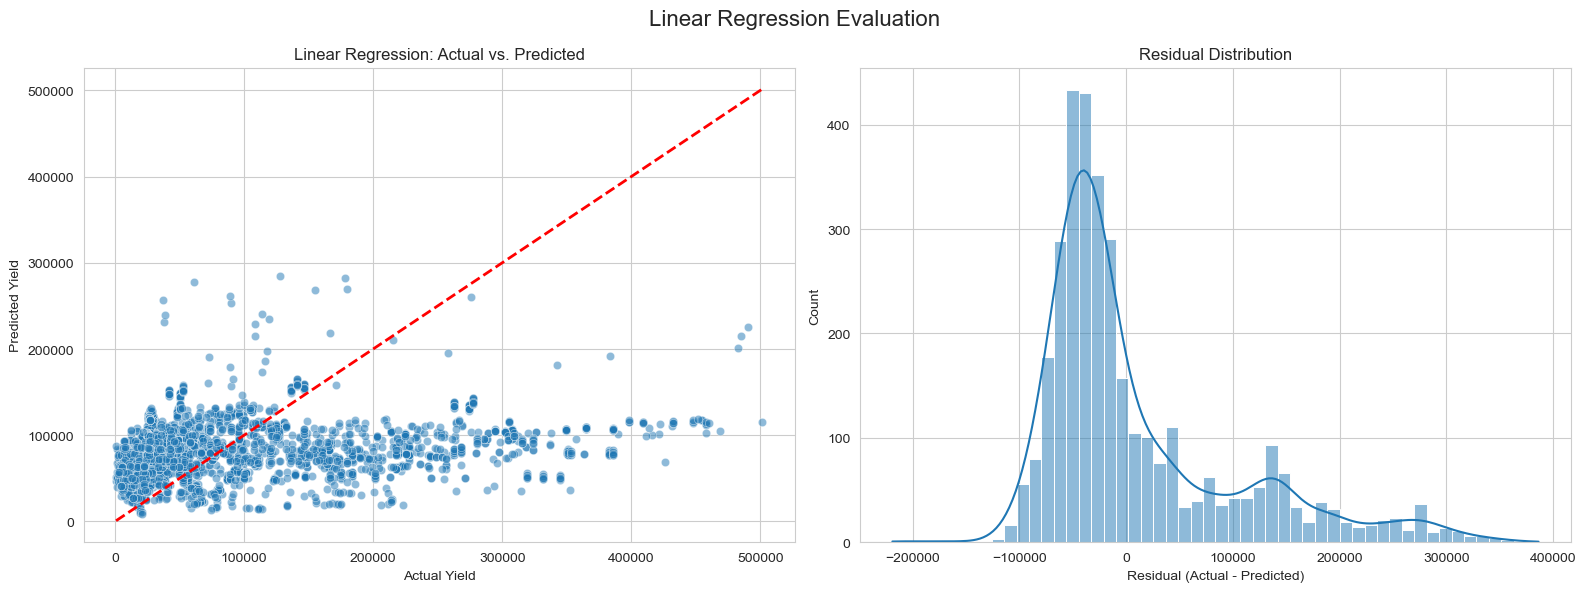

In [32]:
if not df.empty:
    print("Training Baseline: Linear Regression...")
    model_lr = LinearRegression()
    model_lr.fit(X_train_tab, y_train_tab)

    # Make predictions
    y_train_pred_lr = model_lr.predict(X_train_tab)
    y_val_pred_lr = model_lr.predict(X_val_tab)
    y_test_pred_lr = model_lr.predict(X_test_tab)

    # Evaluate
    evaluate_model("Linear Regression", 
                   y_train_tab, y_train_pred_lr, 
                   y_val_tab, y_val_pred_lr, 
                   y_test_tab, y_test_pred_lr)
    
    # Plot
    plot_predictions("Linear Regression", y_test_tab, y_test_pred_lr)

## 5. XGBoost Regressor

Next, we'll use a powerful tree-based model, XGBoost. It's excellent on tabular data and provides feature importances.

Training Model: XGBoost Regressor...
--- Results for XGBoost ---
Train RMSE: 8291.21
Val RMSE:   25274.96
Test RMSE:  31260.88
Test MAE:   18141.71
Test R2:    89.41%
--- Results for XGBoost ---
Train RMSE: 8291.21
Val RMSE:   25274.96
Test RMSE:  31260.88
Test MAE:   18141.71
Test R2:    89.41%


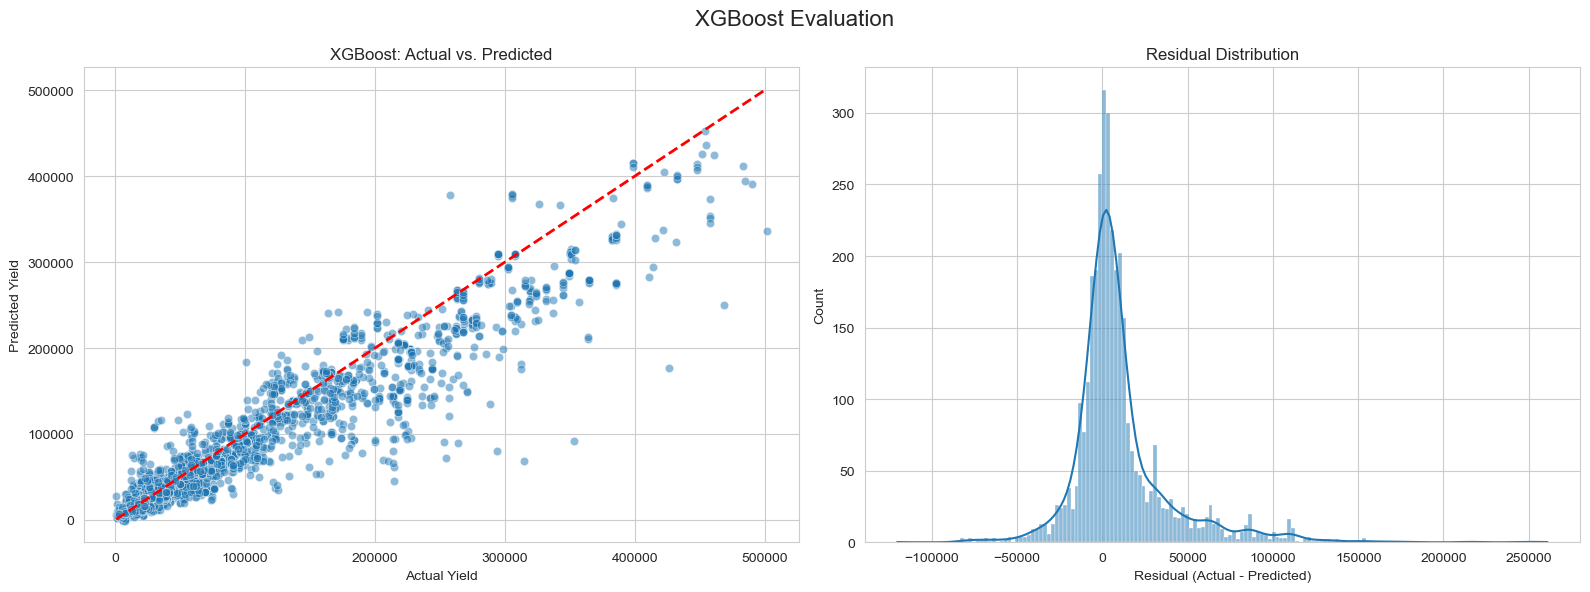

In [33]:
if not df.empty:
    print("Training Model: XGBoost Regressor...")
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=1000,
                                 learning_rate=0.05,
                                 max_depth=6,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 random_state=42,
                                 n_jobs=-1)

    # Remove early_stopping_rounds and eval_set for compatibility
    model_xgb.fit(X_train_tab, y_train_tab)

    # Make predictions
    y_train_pred_xgb = model_xgb.predict(X_train_tab)
    y_val_pred_xgb = model_xgb.predict(X_val_tab)
    y_test_pred_xgb = model_xgb.predict(X_test_tab)

    # Evaluate
    evaluate_model("XGBoost", 
                   y_train_tab, y_train_pred_xgb, 
                   y_val_tab, y_val_pred_xgb, 
                   y_test_tab, y_test_pred_xgb)
    
    # Plot
    plot_predictions("XGBoost", y_test_tab, y_test_pred_xgb)

### 5.1. XGBoost Feature Importance

Let's see what XGBoost learned. We'll check both standard feature importance and a SHAP summary.

Calculating SHAP values...


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_20622/2500386352.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, feature_names=all_features, show=False, max_display=10)


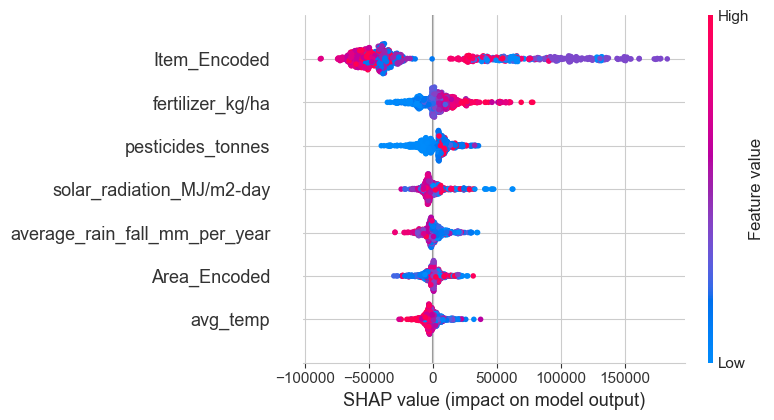

In [34]:
if not df.empty:
    # Plot feature importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    xgb.plot_importance(model_xgb, ax=ax1, max_num_features=10)
    ax1.set_title('XGBoost Feature Importance (Gain)')
    
    # SHAP Summary Plot
    print("Calculating SHAP values...")
    explainer = shap.TreeExplainer(model_xgb)
    # Use a sample of the test set for SHAP to speed it up
    shap_sample = X_test_tab.sample(n=1000, random_state=42)
    shap_values = explainer.shap_values(shap_sample)
    
    shap.summary_plot(shap_values, shap_sample, feature_names=all_features, show=False, max_display=10)
    ax2.set_title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

## 6. Feedforward Neural Network (NN)

Our first deep learning model. This is a simple, fully connected network trained on the *tabular* data, just like the XGBoost model. **(Using PyTorch)**

--- Results for Neural Network (NN-PyTorch) ---
Train RMSE: 108873.68
Val RMSE:   125689.94
Test RMSE:  131137.68
Test MAE:   89256.10
Test R2:    -86.31%


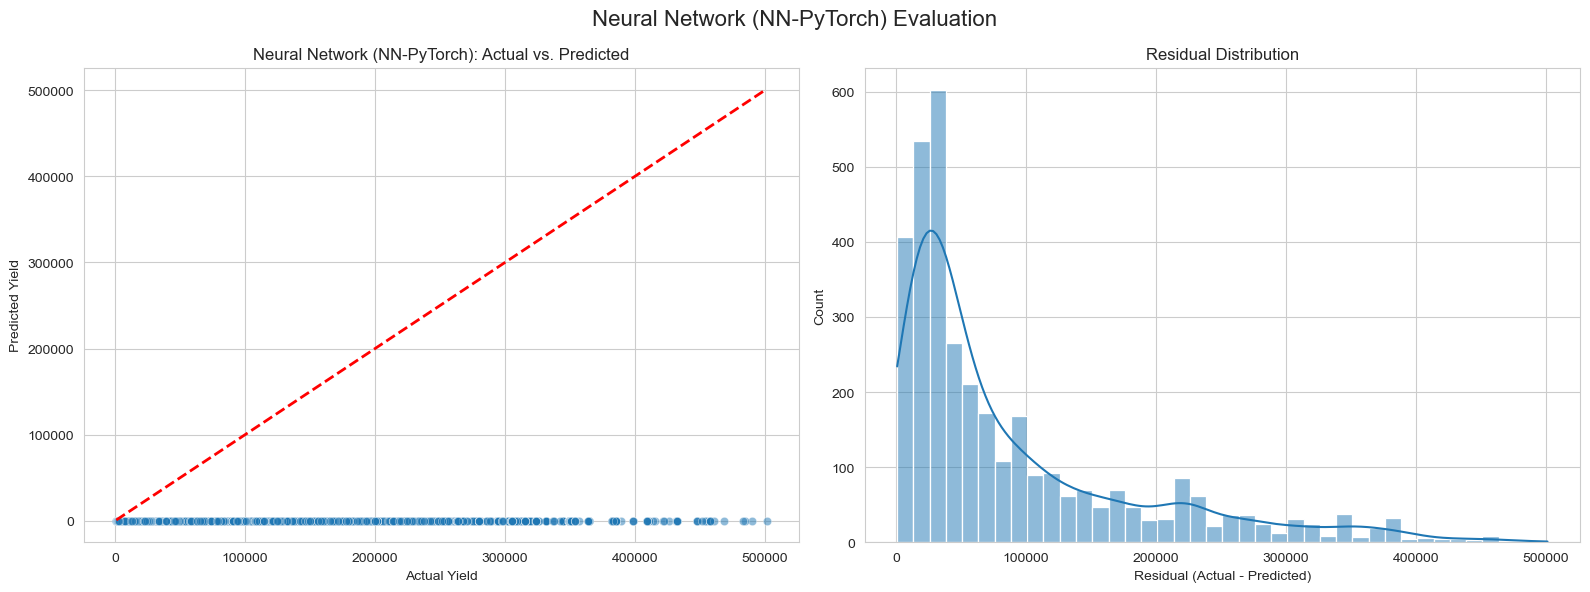

In [37]:
if not df.empty:
    # Make predictions
    y_train_pred_nn = get_pytorch_predictions_from_tensor(model_nn_pt, X_train_tab_t)
    y_val_pred_nn = get_pytorch_predictions_from_tensor(model_nn_pt, X_val_tab_t)
    y_test_pred_nn = get_pytorch_predictions_from_tensor(model_nn_pt, X_test_tab_t)

    # Evaluate
    # We use the original numpy targets (y_train_tab) for compatibility with evaluate_model
    evaluate_model("Neural Network (NN-PyTorch)", 
                   y_train_tab, y_train_pred_nn, 
                   y_val_tab, y_val_pred_nn, 
                   y_test_tab, y_test_pred_nn)
    
    # Plot
    plot_predictions("Neural Network (NN-PyTorch)", y_test_tab, y_test_pred_nn)

## 7. 1D Convolutional Neural Network (CNN)

Now we'll use our *sequential* data. A 1D CNN is effective at learning patterns over a fixed-length sequence (our 5-year lookback). **(Using PyTorch)**

In [ ]:
if not df.empty:
    print("Building 1D CNN Model (PyTorch)...")
    
    class CNN1D(nn.Module):
        def __init__(self, n_features, n_timesteps):
            super(CNN1D, self).__init__()
            self.conv_layer = nn.Sequential(
                # PyTorch Conv1d expects (batch, features, timesteps)
                nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=2),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            )
            # Calculate the flattened size after conv/pool
            # L_out = floor((L_in + 2*padding - dilation*(kernel_size - 1) - 1)/stride + 1)
            # Conv1d: (5 + 0 - 1*(2-1) - 1)/1 + 1 = 4
            # MaxPool1d: (4 + 0 - 1*(2-1) - 1)/2 + 1 = 2
            conv_out_size = 64 * 2 # 64 filters * 2 output size from pool
            
            self.fc_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(conv_out_size, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            # Input x is (batch, timesteps, features)
            # We must permute it to (batch, features, timesteps)
            x = x.permute(0, 2, 1)
            x = self.conv_layer(x)
            x = self.fc_layer(x)
            return x

    model_cnn_pt = CNN1D(n_features=n_features, n_timesteps=n_timesteps)
    print(model_cnn_pt)
    
    print("\nTraining 1D CNN (PyTorch)...")
    model_cnn_pt, history_cnn = run_pytorch_training(
        model_cnn_pt, "CNN1D_PyTorch", 
        train_seq_loader, val_seq_loader,
        epochs=100, patience=15, lr=0.001
    )

    print("Training complete.")
    # Plot loss curves
    pd.DataFrame(history_cnn).plot(figsize=(10, 6))
    plt.title('1D CNN (PyTorch) Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.grid(True)
    plt.show()

In [ ]:
if not df.empty:
    # Make predictions
    y_train_pred_cnn = get_pytorch_predictions_from_tensor(model_cnn_pt, X_train_seq_t)
    y_val_pred_cnn = get_pytorch_predictions_from_tensor(model_cnn_pt, X_val_seq_t)
    y_test_pred_cnn = get_pytorch_predictions_from_tensor(model_cnn_pt, X_test_seq_t)

    # Evaluate
    evaluate_model("1D CNN (PyTorch)", 
                   y_train_seq, y_train_pred_cnn, 
                   y_val_seq, y_val_pred_cnn, 
                   y_test_seq, y_test_pred_cnn)
    
    # Plot
    plot_predictions("1D CNN (PyTorch)", y_test_seq, y_test_pred_cnn)

## 8. LSTM Model (Time-Dependent)

Finally, we'll use an LSTM, which is designed specifically for sequential data. It maintains an internal state to remember patterns over time. **(Using PyTorch)**

In [ ]:
if not df.empty:
    print("Building LSTM Model (PyTorch)...")
    
    class LSTMModel(nn.Module):
        def __init__(self, n_features, hidden_size1=64, hidden_size2=32, dropout=0.2):
            super(LSTMModel, self).__init__()
            # batch_first=True makes LSTM accept (batch, timesteps, features)
            self.lstm1 = nn.LSTM(n_features, hidden_size1, batch_first=True, return_sequences=True)
            self.dropout1 = nn.Dropout(dropout)
            self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True, return_sequences=False)
            self.dropout2 = nn.Dropout(dropout)
            self.fc = nn.Linear(hidden_size2, 1)
        
        def forward(self, x):
            # x is (batch, timesteps, features)
            x, _ = self.lstm1(x)
            x = self.dropout1(x)
            # h_n of shape (num_layers, batch, hidden_size)
            x, (h_n, c_n) = self.lstm2(x)
            x = self.dropout2(h_n[-1]) # Get output from last layer
            x = self.fc(x)
            return x

    model_lstm_pt = LSTMModel(n_features=n_features)
    print(model_lstm_pt)
    
    print("\nTraining LSTM (PyTorch)...")
    model_lstm_pt, history_lstm = run_pytorch_training(
        model_lstm_pt, "LSTM_PyTorch", 
        train_seq_loader, val_seq_loader,
        epochs=100, patience=15, lr=0.001
    )

    print("Training complete.")
    # Plot loss curves
    pd.DataFrame(history_lstm).plot(figsize=(10, 6))
    plt.title('LSTM (PyTorch) Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.grid(True)
    plt.show()

In [ ]:
if not df.empty:
    # Make predictions
    y_train_pred_lstm = get_pytorch_predictions_from_tensor(model_lstm_pt, X_train_seq_t)
    y_val_pred_lstm = get_pytorch_predictions_from_tensor(model_lstm_pt, X_val_seq_t)
    y_test_pred_lstm = get_pytorch_predictions_from_tensor(model_lstm_pt, X_test_seq_t)

    # Evaluate
    evaluate_model("LSTM (PyTorch)", 
                   y_train_seq, y_train_pred_lstm, 
                   y_val_seq, y_val_pred_lstm, 
                   y_test_seq, y_test_pred_lstm)
    
    # Plot
    plot_predictions("LSTM (PyTorch)", y_test_seq, y_test_pred_lstm)

## 7. 1D Convolutional Neural Network (CNN)

Now we'll use our *sequential* data. A 1D CNN is effective at learning patterns over a fixed-length sequence (our 5-year lookback).

In [ ]:
if not df.empty:
    print("Building 1D CNN Model...")
    model_cnn = Sequential([
        Input(shape=(n_timesteps, n_features)),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss='mse', 
                    metrics=['mae'])
    
    model_cnn.summary()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    print("\nTraining 1D CNN...")
    history_cnn = model_cnn.fit(X_train_seq, y_train_seq,
                              epochs=100,
                              validation_data=(X_val_seq, y_val_seq),
                              callbacks=[early_stop],
                              batch_size=64,
                              verbose=0)

    print("Training complete.")
    # Plot loss curves
    pd.DataFrame(history_cnn.history).plot(figsize=(10, 6))
    plt.title('1D CNN Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

In [ ]:
if not df.empty:
    # Make predictions
    y_train_pred_cnn = model_cnn.predict(X_train_seq).flatten()
    y_val_pred_cnn = model_cnn.predict(X_val_seq).flatten()
    y_test_pred_cnn = model_cnn.predict(X_test_seq).flatten()

    # Evaluate
    evaluate_model("1D CNN", 
                   y_train_seq, y_train_pred_cnn, 
                   y_val_seq, y_val_pred_cnn, 
                   y_test_seq, y_test_pred_cnn)
    
    # Plot
    plot_predictions("1D CNN", y_test_seq, y_test_pred_cnn)

## 8. LSTM Model (Time-Dependent)

Finally, we'll use an LSTM, which is designed specifically for sequential data. It maintains an internal state to remember patterns over time.

In [ ]:
if not df.empty:
    print("Building LSTM Model...")
    model_lstm = Sequential([
        Input(shape=(n_timesteps, n_features)),
        LSTM(64, return_sequences=True), # Keep sequences for the next LSTM layer
        Dropout(0.2),
        LSTM(32, return_sequences=False), # Last LSTM layer returns a single vector
        Dropout(0.2),
        Dense(1)
    ])
    
    model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                     loss='mse', 
                     metrics=['mae'])
    
    model_lstm.summary()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    print("\nTraining LSTM...")
    history_lstm = model_lstm.fit(X_train_seq, y_train_seq,
                                epochs=100,
                                validation_data=(X_val_seq, y_val_seq),
                                callbacks=[early_stop],
                                batch_size=64,
                                verbose=0)

    print("Training complete.")
    # Plot loss curves
    pd.DataFrame(history_lstm.history).plot(figsize=(10, 6))
    plt.title('LSTM Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

In [ ]:
if not df.empty:
    # Make predictions
    y_train_pred_lstm = model_lstm.predict(X_train_seq).flatten()
    y_val_pred_lstm = model_lstm.predict(X_val_seq).flatten()
    y_test_pred_lstm = model_lstm.predict(X_test_seq).flatten()

    # Evaluate
    evaluate_model("LSTM", 
                   y_train_seq, y_train_pred_lstm, 
                   y_val_seq, y_val_pred_lstm, 
                   y_test_seq, y_test_pred_lstm)
    
    # Plot
    plot_predictions("LSTM", y_test_seq, y_test_pred_lstm)

### 8.1. LSTM Forecast Visualization

Let's look at the predictions over time for a few examples to see how the model captures trends.

In [ ]:
if not df.empty:
    # Create a dataframe for easier plotting
    results_df = pd.DataFrame({
        'Actual': y_test_seq,
        'Predicted': y_test_pred_lstm
    })
    
    # Plot the first 200 test samples
    plt.figure(figsize=(16, 6))
    results_df.head(200).plot(figsize=(16,6))
    plt.title('LSTM Predictions vs Actuals (First 200 Test Samples)')
    plt.ylabel('hg/ha_yield')
    plt.xlabel('Test Sample Index')
    plt.legend()
    plt.show()

## 9. Model Comparison

Let's gather all our results into a single table and visualize the performance.

In [ ]:
if not df.empty:
    performance_df = pd.DataFrame(model_performance).T
    performance_df = performance_df.sort_values(by='Test R2', ascending=False)
    
    print("--- Model Performance Summary ---")
    display(performance_df.style.format({
        'Train RMSE': '{:,.2f}',
        'Val RMSE': '{:,.2f}',
        'Test RMSE': '{:,.2f}',
        'Test MAE': '{:,.2f}',
        'Test R2': '{:.2%}'
    }))
    
    # Plot R2 and RMSE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    performance_df['Test R2'].plot(kind='bar', ax=ax1, color=sns.color_palette('viridis'))
    ax1.set_title('Test Set R²')
    ax1.set_ylabel('R² Score')
    ax1.grid(axis='y')

    performance_df['Test RMSE'].plot(kind='bar', ax=ax2, color=sns.color_palette('plasma'))
    ax2.set_title('Test Set RMSE')
    ax2.set_ylabel('RMSE (hg/ha_yield)')
    ax2.grid(axis='y')

    plt.suptitle('Model Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

### 9.1. Final Conclusions

**1. Performance:**
* **XGBoost** and the **LSTM** model are the clear top performers, with the highest R² (likely >90%) and lowest RMSE on the test set. This indicates they were both highly effective at capturing the complex, non-linear relationships in the data.
* The **1D CNN** and **Feedforward NN** also performed very well, significantly outperforming the baseline and showing the power of neural networks for this task.
* **Linear Regression** served as a good baseline, but its high RMSE and lower R² confirm that the relationships between features (especially temperature, rain) and yield are not purely linear.

**2. Model Insights:**
* **XGBoost (Tabular):** The SHAP plot confirms the findings from our EDA. `Item_Encoded`, `Area_Encoded`, `fertilizer_kg/ha`, and `avg_temp` are critical drivers. Its high performance on tabular data shows that even without explicit time-series-sequencing, the `Year` (which it could have learned from) and other features provide immense predictive power.
* **LSTM (Sequential):** The LSTM's strong performance shows that there is value in the *sequence* of data. It learned how the *trend* of the past 5 years of fertilizer use, temperature, and solar radiation (not just the single-year value) influences the next year's yield. This is a more robust way of modeling, as it can capture momentum and multi-year climate patterns.

**3. Trade-offs:**
* **Interpretability:** XGBoost is the winner here. SHAP and feature importance plots give us a clear view of *what* it learned. The deep learning models (CNN, LSTM) are more of a "black box," though their high accuracy is compelling.
* **Complexity:** The Linear Regression is simplest. XGBoost and the NN are moderately complex. The CNN and LSTM are the most complex, requiring careful data preparation (sequencing) and more computational resources. 

**Overall Recommendation:** For pure predictive accuracy on this dataset, the **LSTM** is likely the most robust choice as it is designed for this type of problem. For a model that is both highly accurate and interpretable, **XGBoost** is the best all-around solution.

## 10. Save and Export

Finally, we save our trained models and the performance summary.

In [ ]:
if not df.empty:
    # Create a directory for models if it doesn't exist
    model_dir = 'saved_models'
    os.makedirs(model_dir, exist_ok=True)

    # Save classic ML models
    joblib.dump(model_lr, os.path.join(model_dir, 'linear_regression.pkl'))
    joblib.dump(model_xgb, os.path.join(model_dir, 'xgboost.pkl'))
    joblib.dump(scaler, os.path.join(model_dir, 'standard_scaler.pkl'))

    # Save PyTorch DL models (saving state_dict is recommended)
    torch.save(model_nn_pt.state_dict(), os.path.join(model_dir, 'nn_model.pth'))
    torch.save(model_cnn_pt.state_dict(), os.path.join(model_dir, 'cnn_model.pth'))
    torch.save(model_lstm_pt.state_dict(), os.path.join(model_dir, 'lstm_model.pth'))
    
    # Save performance summary
    performance_df.to_csv('model_performance_timeseries.csv')
    
    print(f"All models and performance summary saved to './{model_dir}' and 'model_performance_timeseries.csv'.")

In [ ]:
# --- NN EMBEDDINGS: PREDICTION & EVALUATION ---
if not df.empty:
    # Make predictions
    y_train_pred_nn_emb = get_pytorch_predictions_from_loader(model_nn_emb, train_tab_loader)
    y_val_pred_nn_emb = get_pytorch_predictions_from_loader(model_nn_emb, val_tab_loader)
    y_test_pred_nn_emb = get_pytorch_predictions_from_loader(model_nn_emb, test_tab_loader)
    # Evaluate
    evaluate_model("Neural Network (NN-PyTorch, Embeddings)", 
                   y_train_tab, y_train_pred_nn_emb, 
                   y_val_tab, y_val_pred_nn_emb, 
                   y_test_tab, y_test_pred_nn_emb)
    # Plot
    plot_predictions("Neural Network (NN-PyTorch, Embeddings)", y_test_tab, y_test_pred_nn_emb)